# 87 Rb F=2 Peak Blocked and Unblocked
## from New Data/RbF2 blocked/A0038 and New Data/RbF2/A0038

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import optimize
from scipy.optimize import curve_fit

In [2]:
# Calibration numbers come from multiple calibrations with proper error analysis and weighted averaging
# Calulations can be found in "Multiple Plot Calibration"
CalM = -5.169066740202884
#CalM_err = 1.8472146461547026e-06
CalM_err = 0.36697628437204854

# define functions
def LinearFunc(t, a, b):
    return a * t + b

def ChiSqrd(Data, Fit, Error):
    return sum( (Data - Fit)**2 ) / (Error**2)

def RdChiSqrd(Data, Fit, Error, NumPrams):
    return sum( (Data - Fit)**2 ) / (Error**2 * (np.size(Data) - NumPrams - 2))

def Cali(t, t0, DriveSlope):
    return (10 * DriveSlope * CalM * (t - t0))

def Cali_Err(t, t_err, t0, t0_err, DriveSlope, DriveSlope_err):
    return np.sqrt( (10 * DriveSlope_err * CalM * (t - t0))**2 +
                    (10 * DriveSlope * CalM_err * (t - t0))**2 +
                    (10 * DriveSlope * CalM * t_err)**2 +
                    (10 * DriveSlope * CalM * t0_err)**2 )

def func(x, *params):
    y = np.zeros_like(x)
    for i in range(0, (len(params)-2), 3):
        ctr = params[i]
        amp = params[i+1]
        wid = params[i+2]
        y = y + amp * np.exp( (-1/2) * ((x - ctr)/wid)**2)
    return y + x * params[12] + params[13]

def GausOnLine(x, a, b, amp, ctr, wid):
    return a * x + b + amp * np.exp( -((x - ctr)/wid)**2)

## Blocked Data

3.4738803020921996
0.03350852448526381


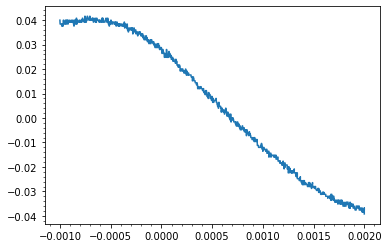

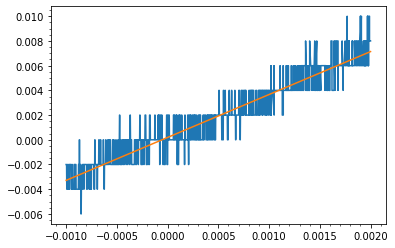

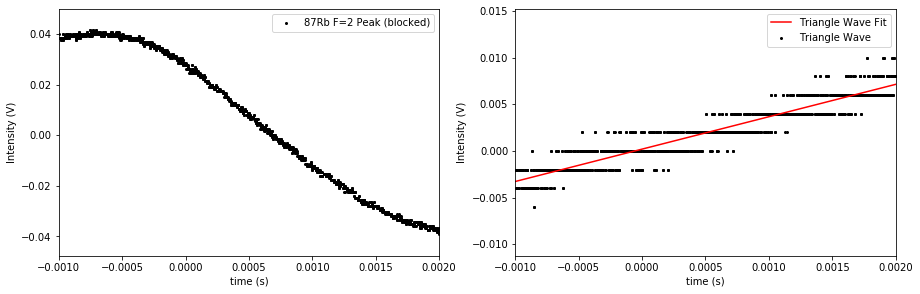

In [4]:
data =  pd.read_csv("New Data/RbF2 blocked/A0038CH1.CSV")
x = pd.DataFrame(data, columns= ['col 1'])
y = pd.DataFrame(data, columns= ['col 2'])
x = np.resize(x,(4000,1))
y = np.resize(y,(4000,1))

rampdata =  pd.read_csv("New Data/RbF2 blocked/A0038CH2.CSV")
rampx = pd.DataFrame(rampdata, columns= ['col 1'])
rampy = pd.DataFrame(rampdata, columns= ['col 2'])
rampx = np.resize(rampx,(4000,1))
rampy = np.resize(rampy,(4000,1))

t_start = -0.001
t_end = 0.002

j = 0
for i in x:
    if i == t_start:
        t1 = j
    if i == t_end:
        t2 = j
    j += 1

x = x[t1:t2,0]
y = y[t1:t2,0]
rampx = rampx[t1:t2,0]
rampy = rampy[t1:t2,0]

RampGuess = [5, -2]
RampParam, RampParam_cov = curve_fit(LinearFunc, rampx, rampy, RampGuess, maxfev=150000)

RampSlope = RampParam[0]
print(RampSlope)
print(np.sqrt(RampParam_cov[0,0]))

plt.plot(x,y)
plt.minorticks_on()
plt.show()
plt.plot(rampx,rampy)
plt.plot(rampx,LinearFunc(rampx,*RampParam))
plt.minorticks_on()
plt.show()


fig = plt.figure(figsize=(15,10))

fig1 = fig.add_subplot(2,2,1)
fig1.scatter(x, y, label='87Rb F=2 Peak (blocked)', color='black', s=4)
fig1.set_xlim(t_start,t_end)
fig1.set_xlabel("time (s)")
fig1.set_ylabel("Intensity (V)")
fig1.legend();

fig2 = fig.add_subplot(2,2,2)
fig2.scatter(rampx, rampy, label='Triangle Wave', color='black', s=4)
fig2.plot(rampx, LinearFunc(rampx,*RampParam), label='Triangle Wave Fit', color='red')
fig2.set_xlim(t_start,t_end)
fig2.set_xlabel("time (s)")
fig2.set_ylabel("Intensity (V)")
fig2.legend();

Y-error = (+/-) 0.0007162505528707778
[-4.17731753e+01  2.87034811e-02]


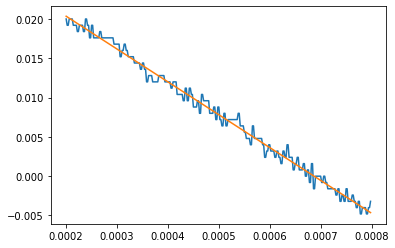

In [5]:
# Finds Error in the voltage

# Find flat '0' segments
# Here I'm taking from t=-0.0001 to t=0.0001
j = 0
for i in x: 
    if i == 0.0002:
        t1 = j
    if i == 0.0008:
        t2 = j
    j += 1
    
x_back = x[t1:t2]
y_back = y[t1:t2]

Back_guess = [-18,-.014]

Back_popt, Back_pcov = optimize.curve_fit(LinearFunc, x_back, y_back, Back_guess, maxfev=150000)

V_error = np.sqrt( sum( (y_back - LinearFunc(x_back, *Back_popt))**2 ) / (np.size(x_back) - 2) )

print("Y-error = (+/-) " + str(V_error))

print(Back_popt)

plt.plot(x_back,y_back)
plt.plot(x_back, LinearFunc(x_back, *Back_popt))
plt.show()

V_errorA = V_error * np.linspace(1,1,np.size(x))
    

Reduced Chi Squared = 1.1408479821952482


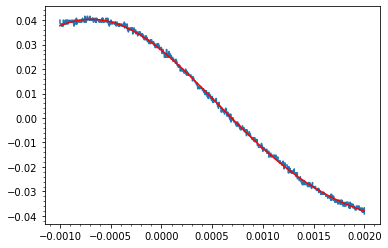

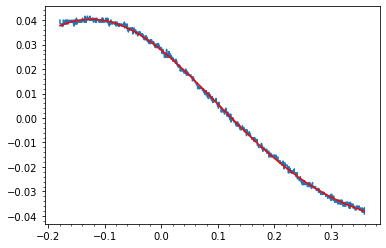

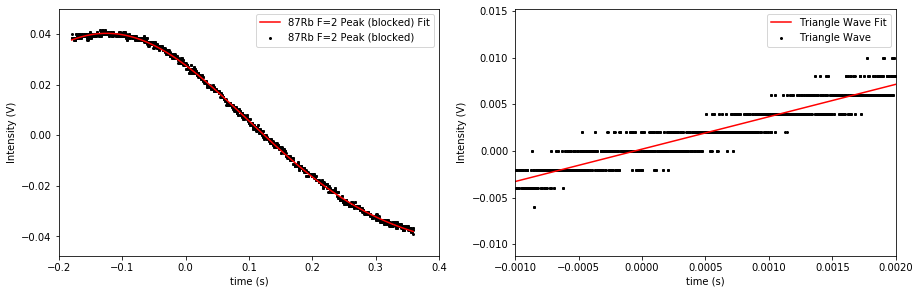

In [9]:
# Fit curve, apply Calibration, fit again
# GausOnLine(x, a, b, amp, ctr, wid)

guess = [-21, -0.019, 0.04, -0.0008, 0.003]

popt, pcov = optimize.curve_fit(GausOnLine, x, y, p0=guess, sigma= V_errorA, maxfev=150000)
fit = GausOnLine(x, *popt)

#print("87Rb F=1 Peak Position: " + str(popt[9]) + " +/- " + str(np.sqrt(pcov[9,9])) )
RCS = RdChiSqrd(y, GausOnLine(x, *popt), V_error, 5)
print("Reduced Chi Squared = " + str(RCS))

plt.plot(x, y)
plt.plot(x, fit , 'r-')
plt.minorticks_on()
plt.show()


# Calibration
#Calx = (-1)*Cali(x, popt[3], RampSlope)
Calx = (-1)*Cali(x, 0.0, RampSlope)


plt.plot(Calx, y)
plt.plot(Calx, GausOnLine(x, *popt) , 'r-')
plt.minorticks_on()
plt.show()

fig = plt.figure(figsize=(15,10))

fig1 = fig.add_subplot(2,2,1)
fig1.scatter(Calx, y, label='87Rb F=2 Peak (blocked)', color='black', s=4)
fig1.plot(Calx, GausOnLine(x, *popt), label='87Rb F=2 Peak (blocked) Fit', color='red')
fig1.set_xlim(-0.2,0.4)
fig1.set_xlabel("Relative Frequency (GHz)")
fig1.set_ylabel("Intensity (V)")
fig1.legend();

fig2 = fig.add_subplot(2,2,2)
fig2.scatter(rampx, rampy, label='Triangle Wave', color='black', s=4)
fig2.plot(rampx, LinearFunc(rampx,*RampParam), label='Triangle Wave Fit', color='red')
fig2.set_xlim(t_start,t_end)
fig2.set_xlabel("time (s)")
fig2.set_ylabel("Intensity (V)")
fig2.legend();

In [10]:
Blx = x
Bly = y
BlV_errorA = V_errorA

## Unblocked Data

3.494076364140503
0.03589038520943073


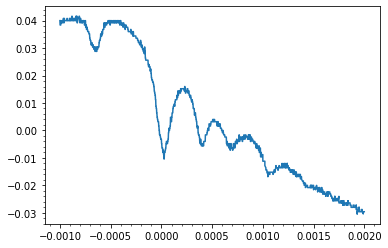

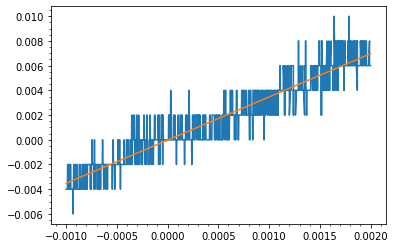

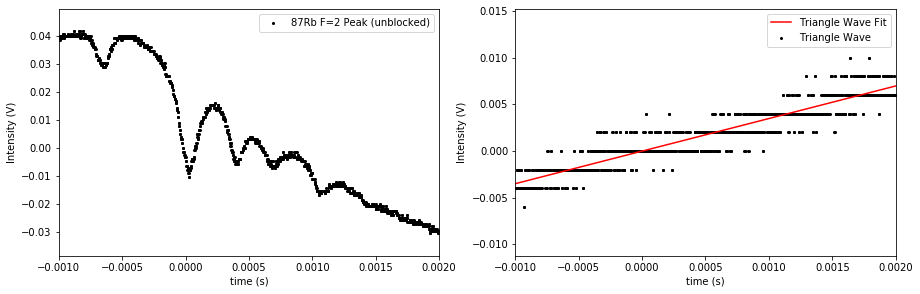

In [12]:
data =  pd.read_csv("New Data/RbF2/A0037CH1.CSV")
x = pd.DataFrame(data, columns= ['col 1'])
y = pd.DataFrame(data, columns= ['col 2'])
x = np.resize(x,(4000,1))
y = np.resize(y,(4000,1))

rampdata =  pd.read_csv("New Data/RbF2/A0037CH2.CSV")
rampx = pd.DataFrame(rampdata, columns= ['col 1'])
rampy = pd.DataFrame(rampdata, columns= ['col 2'])
rampx = np.resize(rampx,(4000,1))
rampy = np.resize(rampy,(4000,1))

t_start = -0.001
t_end = 0.002

j = 0
for i in x:
    if i == t_start:
        t1 = j
    if i == t_end:
        t2 = j
    j += 1

x = x[t1:t2,0]
y = y[t1:t2,0]
rampx = rampx[t1:t2,0]
rampy = rampy[t1:t2,0]

RampGuess = [5, -2]
RampParam, RampParam_cov = curve_fit(LinearFunc, rampx, rampy, RampGuess, maxfev=150000)

RampSlope = RampParam[0]
RampSlope_err = np.sqrt(RampParam_cov[0,0])

print(RampSlope)
print(RampSlope_err)

plt.plot(x,y)
plt.minorticks_on()
plt.show()
plt.plot(rampx,rampy)
plt.plot(rampx,LinearFunc(rampx,*RampParam))
plt.minorticks_on()
plt.show()

fig = plt.figure(figsize=(15,10))

fig1 = fig.add_subplot(2,2,1)
fig1.scatter(x, y, label='87Rb F=2 Peak (unblocked)', color='black', s=4)
fig1.set_xlim(t_start, t_end)
fig1.set_xlabel("time (s)")
fig1.set_ylabel("Intensity (V)")
fig1.legend();

fig2 = fig.add_subplot(2,2,2)
fig2.scatter(rampx, rampy, label='Triangle Wave', color='black', s=4)
fig2.plot(rampx, LinearFunc(rampx,*RampParam), label='Triangle Wave Fit', color='red')
fig2.set_xlim(t_start,t_end)
fig2.set_xlabel("time (s)")
fig2.set_ylabel("Intensity (V)")
fig2.legend();

Y-error = (+/-) 0.0006620044095487102
[-1.85487996e+01  7.14503543e-03]


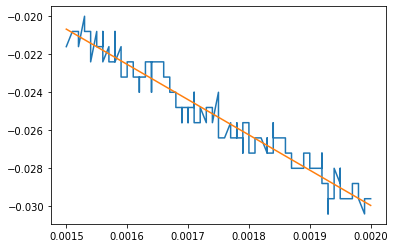

In [13]:
# Finds Error in the voltage

# Find flat '0' segments
# Here I'm taking from t=-0.0001 to t=0.0001
j = 0
for i in x: 
    if i == 0.0015:
        t1 = j
    if i == 0.002:
        t2 = j
    j += 1
    
x_back = x[t1:t2]
y_back = y[t1:t2]

Back_guess = [40,0.085]

Back_popt, Back_pcov = optimize.curve_fit(LinearFunc, x_back, y_back, Back_guess, maxfev=150000)

V_error = np.sqrt( sum( (y_back - LinearFunc(x_back, *Back_popt))**2 ) / (np.size(x_back) - 2) )

print("Y-error = (+/-) " + str(V_error))

print(Back_popt)

plt.plot(x_back,y_back)
plt.plot(x_back, LinearFunc(x_back, *Back_popt))
plt.show()

V_errorA = V_error * np.linspace(1,1,np.size(x))
    

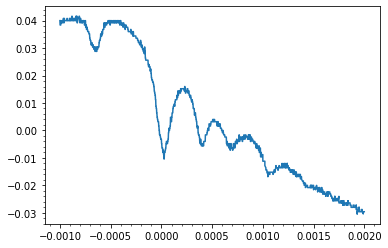

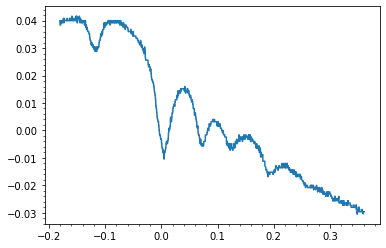

In [15]:
# Fit curve, apply Calibration, fit again
# GausOnLine(x, a, b, amp, ctr, wid)

plt.plot(x, y)
plt.minorticks_on()
plt.show()

# Calibration
Calx = (-1)*Cali(x, 0.0, RampSlope)

plt.plot(Calx, y)
plt.minorticks_on()
plt.show()

In [16]:
UnBlx = x
UnBly = y
UnV_errorA = V_errorA

# Putting them together

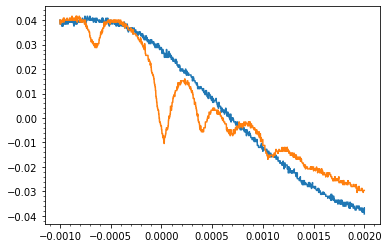

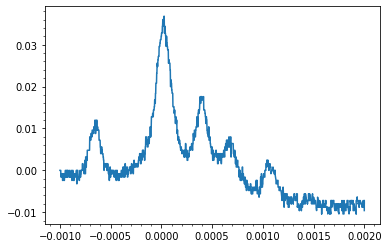

In [17]:
# Uncalibrated togther
plt.plot(x, Bly)
plt.plot(x, UnBly)
plt.minorticks_on()
plt.show()

diff = Bly-UnBly
diff_err = np.sqrt( (BlV_errorA)**2 + (UnV_errorA)**2)

# Uncalibrated difference
plt.plot(x , diff)
plt.minorticks_on()
plt.show()

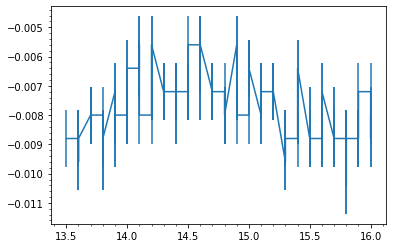

(array([28, 29, 34, 35, 50, 51, 54, 55, 66, 67], dtype=int64),)
14.499999999999998
0.7999999999999999


In [18]:
#Finding F'=1 Peak position
#Narrowing it down
j = 0
for i in x: 
    if i == 0.00135:
        t1 = j
    if i == 0.0016:
        t2 = j
    j += 1
    
x1 = x[t1:t2]
diff1 = diff[t1:t2]
diff_err1 = diff_err[t1:t2]
plt.errorbar(x1*10000, diff1, yerr=diff_err1)
plt.minorticks_on()
plt.show()

print(np.where(diff1 == max(diff1)))

F1PeakPos =    (x1[67]+x1[28])/2
F1PeakPos_err = x1[67]-x1[28]

print( F1PeakPos * 10000 )
print( F1PeakPos_err * 10000 )

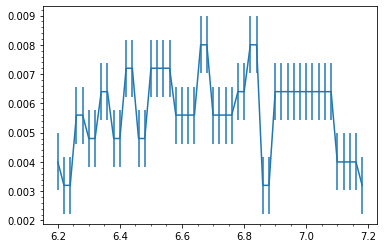

(array([23, 24, 31, 32], dtype=int64),)
6.670000000000001
0.14000000000000015


In [19]:
#Finding F'=2 Peak position
#Narrowing it down
j = 0
for i in x: 
    if i == 0.00062:
        t1 = j
    if i == 0.00072:
        t2 = j
    j += 1
    
x2 = x[t1:t2]
diff2 = diff[t1:t2]
diff_err2 = diff_err[t1:t2]
plt.errorbar(x2*10000, diff2, yerr=diff_err2)
plt.minorticks_on()
plt.show()

print(np.where(diff2 == max(diff2)))

F2PeakPos = (x2[27]+x2[20])/2
F2PeakPos_err = x2[27]-x2[20]

print( F2PeakPos * 10000 )
print( F2PeakPos_err * 10000 )

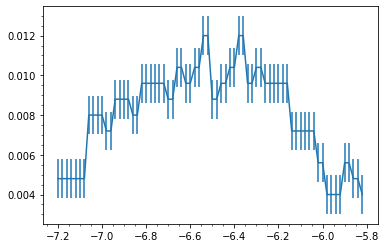

(array([33, 34, 41, 42], dtype=int64),)
-6.449999999999999
0.17999999999999897


In [20]:
#Finding F'=3 Peak position
#Narrowing it down
j = 0
for i in x: 
    if i == -0.00072:
        t1 = j
    if i == -0.00058:
        t2 = j
    j += 1
    
x3 = x[t1:t2]
diff3 = diff[t1:t2]
diff_err3 = diff_err[t1:t2]
plt.errorbar(x3*10000, diff3, yerr=diff_err3)
plt.minorticks_on()
plt.show()

print(np.where(diff3 == max(diff3)))

F3PeakPos = (x3[42]+x3[33])/2
F3PeakPos_err = x3[42]-x3[33]

print( F3PeakPos * 10000 )
print( F3PeakPos_err * 10000 )


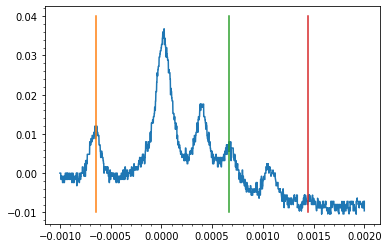

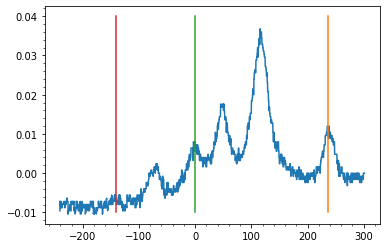

-141.4185220061882
17.834658151034766

236.96181465149294
17.49003714268511


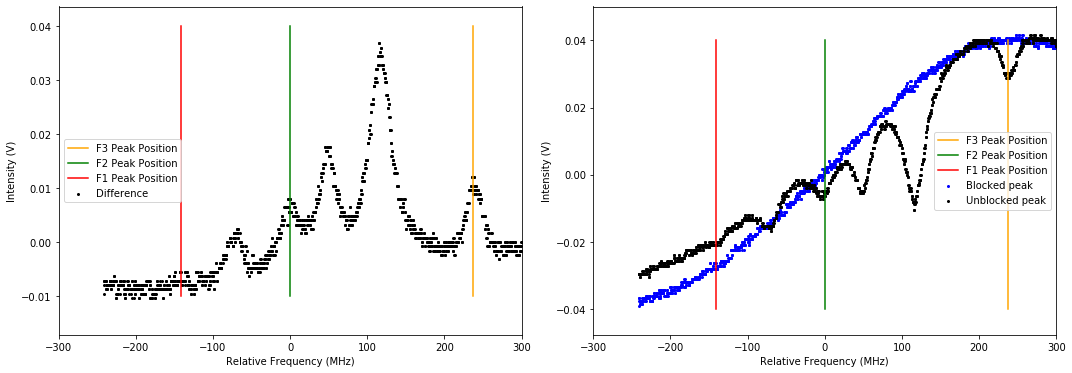

In [25]:
# Uncalibrated difference
plt.plot(x , diff)
plt.plot([F3PeakPos, F3PeakPos], [-.01, .04])
plt.plot([F2PeakPos, F2PeakPos], [-.01, .04])
plt.plot([F1PeakPos, F1PeakPos], [-.01, .04])
plt.minorticks_on()
plt.show()

Calx = 1000 * Cali(x, F2PeakPos, RampSlope)
CalF1PeakPos = 1000 * Cali(F1PeakPos, F2PeakPos, RampSlope)
CalF3PeakPos = 1000 * Cali(F3PeakPos, F2PeakPos, RampSlope)

#Cali_Err(t, t_err, t0, t0_err, DriveSlope, DriveSlope_err)
CalF1PeakPos_err = 1000 * Cali_Err(F1PeakPos, F1PeakPos_err, F2PeakPos, F2PeakPos_err, RampSlope, RampSlope_err)
CalF2PeakPos_err = 1000 * Cali_Err(F2PeakPos, F2PeakPos_err, F2PeakPos, F2PeakPos_err, RampSlope, RampSlope_err)
CalF3PeakPos_err = 1000 * Cali_Err(F3PeakPos, F3PeakPos_err, F2PeakPos, F2PeakPos_err, RampSlope, RampSlope_err)

# Calibrated difference
plt.plot(Calx , diff)
plt.plot([CalF3PeakPos, CalF3PeakPos], [-.01, .04])
plt.plot([0, 0], [-.01, .04])
plt.plot([CalF1PeakPos, CalF1PeakPos], [-.01, .04])
plt.minorticks_on()
plt.show()


fig = plt.figure(figsize=(15,10))

fig1 = fig.add_subplot(2,2,1)
fig1.scatter(Calx, diff, label='Difference', color='black', s=4)
fig1.plot([CalF3PeakPos, CalF3PeakPos], [-.01, .04], label='F3 Peak Position', color='orange')
fig1.plot([0, 0], [-.01, .04], label='F2 Peak Position', color='green')
fig1.plot([CalF1PeakPos, CalF1PeakPos], [-.01, .04], label='F1 Peak Position', color='red')
fig1.set_xlim(-300,300)
fig1.set_xlabel("Relative Frequency (MHz)")
fig1.set_ylabel("Intensity (V)")
fig1.legend();

fig2 = fig.add_subplot(2,2,2)
fig2.scatter(Calx, Bly, label='Blocked peak', color='blue', s=4)
fig2.scatter(Calx, UnBly, label='Unblocked peak', color='black', s=4)
fig2.plot([CalF3PeakPos, CalF3PeakPos], [-.04, .04], label='F3 Peak Position', color='orange')
fig2.plot([0, 0], [-.04, .04], label='F2 Peak Position', color='green')
fig2.plot([CalF1PeakPos, CalF1PeakPos], [-.04, .04], label='F1 Peak Position', color='red')
fig2.set_xlim(-300,300)
fig2.set_xlabel("Relative Frequency (MHz)")
fig2.set_ylabel("Intensity (V)")
fig2.legend();

fig.tight_layout()

print(CalF1PeakPos)
print(CalF1PeakPos_err)
print("")
print(CalF3PeakPos)
print(CalF3PeakPos_err)